## Import required libraries

In [1]:
import cv2
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Activation, Flatten, SeparableConv2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd 
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## Preprocessing

- Augment data (rescale, zoom, flip horizontally)
- Create data generator for train/test/val split
- Binarize testing labels

In [2]:
def generate(px, batch_size):
    '''
    Creates generators for train/test/val splits to pull images from disk,
    and applies various augmentations to the training and validation sets.
    '''
    
    train_gen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.3,
        horizontal_flip = True).flow_from_directory(
            directory = './train', 
            target_size = (px, px), 
            batch_size = batch_size, 
            class_mode = 'binary', 
            shuffle = True)

    val_gen = ImageDataGenerator(
        rescale = 1./255,
        zoom_range = 0.3,
        horizontal_flip = True).flow_from_directory(
            directory = './val', 
            target_size = (px, px), 
            batch_size = batch_size, 
            class_mode = 'binary', 
            shuffle = True)
        
    test_gen = ImageDataGenerator().flow_from_directory(
        directory = './test', 
        target_size = (px, px), 
        batch_size = batch_size, 
        class_mode = 'binary', 
        shuffle = True)

    train_steps = train_gen.samples // batch_size
    val_steps = val_gen.samples // batch_size
    
    return train_gen, val_gen, test_gen, train_steps, val_steps

In [3]:
def prep_test(px):
    '''
    Prepares test data by creating two np arrays of the resized test images and binarized labels.
    '''
    test_data = []
    test_labels = []

    for dirname in ['/NORMAL/', '/PNEUMONIA/']:
        for file in (os.listdir('./test' + dirname)):
            image = cv2.resize(plt.imread('./test'+ dirname + file), (px, px))
            
            test_data.append(np.dstack([image, image, image]).astype('float32') / 255)
            test_labels.append(0 if dirname == '/NORMAL/' else 1)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return test_data, test_labels

## Define Neural Network

- Set random seed
- Define hyperparameters
- Construct neural network

In [4]:
np.random.seed(420)

px = 150
epochs = 10
batch_size = 32

train_gen, val_gen, test_gen, train_steps, val_steps = generate(px, batch_size)
test_data, test_labels = prep_test(px)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
input_layer = Input(shape=(px, px, 3))

model = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
model = Conv2D(16, (3, 3), activation='relu', padding='same')(model)
model = MaxPool2D(pool_size=(2, 2))(model)

model = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)

model = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)

model = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Dropout(rate=0.2)(model)

model = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(model)
model = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(model)
model = BatchNormalization()(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Dropout(rate=0.2)(model)

model = Flatten()(model)
model = Dense(units=512, activation='relu')(model)
model = Dropout(rate=0.7)(model)
model = Dense(units=128, activation='relu')(model)
model = Dropout(rate=0.5)(model)
model = Dense(units=64, activation='relu')(model)
model = Dropout(rate=0.3)(model)

output_layer = Dense(units=1, activation='sigmoid')(model)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

## Fit model to data

In [7]:
checkpoint = ModelCheckpoint(filepath = './weights.hdf5', save_best_only = True, save_weights_only = True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', mode = 'max', factor = 0.3, patience = 2, verbose = 1)

history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_steps, 
    epochs = epochs,
    validation_data = val_gen, 
    validation_steps = val_steps,
    callbacks = [checkpoint, lr_reduce])

Epoch 1/10
163/163 [==============================] - 123s 755ms/step - loss: 0.3732 - accuracy: 0.8265 - val_loss: 0.9685 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.96855, saving model to ./weights.hdf5
Epoch 2/10
163/163 [==============================] - 120s 737ms/step - loss: 0.2710 - accuracy: 0.8907 - val_loss: 1.6153 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.96855
Epoch 3/10
163/163 [==============================] - 121s 739ms/step - loss: 0.2166 - accuracy: 0.9197 - val_loss: 1.9994 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.96855

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
163/163 [==============================] - 120s 733ms/step - loss: 0.1833 - accuracy: 0.9302 - val_loss: 3.0052 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.96855
Epoch 5/10
163/163 [==============================] - 120s 736ms/step - loss: 0.1610 - accuracy

## Evaluate performance

- Training accuracy and loss
- Confusion matrix
- Various metrics

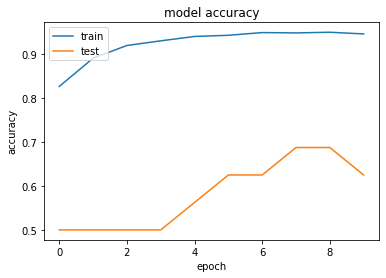

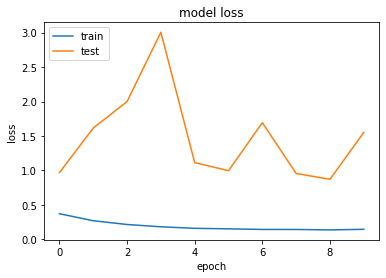

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

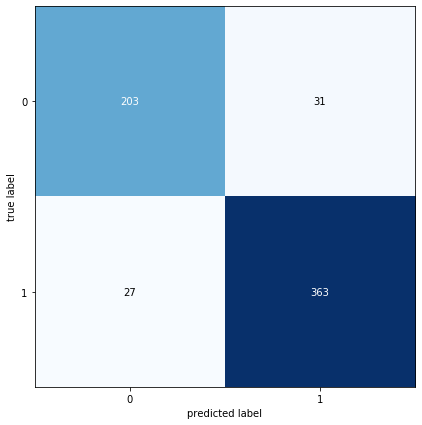

Precision = (True Positive)/(True Positive + False Positive)
	= (363)/(363 + 31)
	= 92.132%

Recall = (True Positive)/(True Positive + False Negative)
	= (363)/(363 + 27)
	= 93.0769%

Accuracy = (True Positive + True Negative)/(All Predictions)
	= (363 + 203)/(363 + 27 + 31 + 203)
	= 90.7051%

F1 Score = (2 * Precision * Recall)/(Precision + Recall)
	= 92.602%

Training Accuracy = 94.5936%

════════════════════════════════════════════════════════

92.13% of the samples that the model classifies as pneumonia actually have pneumonia.

93.08% of the samples that exhibit symptoms of pneumonia are predicted correctly.

90.71% of all predictions are correct.


In [10]:
model.load_weights('weights.hdf5')
preds = model.predict(test_data)

CM = confusion_matrix(test_labels, np.round(preds))

plot_confusion_matrix(CM ,  figsize = (7, 7))
plt.show()

precision = (CM[1][1]/(CM[1][1] + CM[0][1]))
print('Precision = (True Positive)/(True Positive + False Positive)\n\t= ({})/({} + {})\n\t= {}%'\
      .format(CM[1][1], CM[1][1], CM[0][1],\
             round(100 * precision, 4)))

recall = (CM[1][1]/(CM[1][1] + CM[1][0]))
print('\nRecall = (True Positive)/(True Positive + False Negative)\n\t= ({})/({} + {})\n\t= {}%'\
      .format(CM[1][1], CM[1][1], CM[1][0],\
             round(100 * recall, 4)))

accuracy = (CM[1][1] + CM[0][0])/(CM[1][1] + CM[1][0] + CM[0][1] + CM[0][0])
print('\nAccuracy = (True Positive + True Negative)/(All Predictions)\n\t= ({} + {})/({} + {} + {} + {})\n\t= {}%'\
      .format(CM[1][1], CM[0][0], CM[1][1], CM[1][0], CM[0][1], CM[0][0],\
             round(100 * accuracy, 4)))

print('\nF1 Score = (2 * Precision * Recall)/(Precision + Recall)\n\t= {}%'\
     .format(round((100 * 2 * precision * recall)/(precision + recall), 4)))

print('\nTraining Accuracy = {}%'\
     .format(round(100 * history.history['accuracy'][-1], 4)))

print("\n════════════════════════════════════════════════════════")
print('\n{}% of the samples that the model classifies as pneumonia actually have pneumonia.'\
      .format(round(100 * precision, 2)))

print('\n{}% of the samples that exhibit symptoms of pneumonia are predicted correctly.'\
      .format(round(100 * recall, 2)))

print('\n{}% of all predictions are correct.'\
      .format(round(100 * accuracy, 2)))